<b>Jelle Assink (2021)</b><br>
<i>assink@knmi.nl</i><br>
Royal Netherlands Meteorological Institute (KNMI)

In this notebook we compare the rain that is computed on hybrid model level 60 (level type 109) and the model level above the ground (level 105). The rain parameter is computed in mm/h. In the case of the hybrid model level, the rain field has to be multiplied with a precipitation velocity factor, which in this case is assumed to be 10 m/s.

In [1]:
from griblib import HARMONIE
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [3]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': 10.0, 'max': 25.0}
wind_lim = {'min': 2.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 15.0}

# interpolation point
lon = 4.0
lat = 52.0

In [4]:
#fid_grib = 'cy36/20170529_00/HARM_N25_201705290000_00300_GB'
fid_grib = 'cy36/20170529_03/HARM_N25_201705290300_00000_GB'
#fid_grib = 'cy36/20170529_06/HARM_N25_201705290600_00200_GB'
fid_profile = 'harm20170529-04.dat'
fid_provinces = '/Users/assink/infrasound/network/maps/NL/GMT/Provinciegrenzen_2018-shp/Provinciegrenzen_2018.shp'

In [5]:
prov2018 = list(shpreader.Reader(fid_provinces).geometries())

In [6]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'range-azimuth'
path_params['start'] = dict(lat=51.0, lon=0.0)
# path_params['end'] = dict(lat=54.0, lon=9.0)
path_params['range'] = 700.0e3
path_params['azimuth'] = 60.0
dr = 1.0e3

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)
path_params['end'] = dict(lat=lats[-1], lon=lons[-1])

In [7]:
my_atmos = HARMONIE(cycle='36')

In [8]:
request = [
    {'level_type': 'hybrid', 'var_list': ['lsp']},
]

ds1 = my_atmos.read_grib(fid_grib, request, pv_coefficients=False, compat='override')

request = [
    {'level_type': 'heightAboveGround', 'var_list': ['tp']},
]

ds2 = my_atmos.read_grib(fid_grib, request, pv_coefficients=False, compat='override')

********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00000_GB ]

Reading lsp on hybrid level
********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00000_GB ]

Reading tp on heightAboveGround level


In [9]:
ds2

<xarray.Dataset>
Dimensions:            (latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] ...
Data variables:
    tp                 (latitude, longitude) float32 ...

In [10]:
t_fcst=(ds1.valid_time).dt.strftime('%Y%m%d-%H').values

In [11]:
rain_105 = ds2['tp']
#rain_105 = ds2['rain'].sel(heightAboveGround=456)
rain_105 *= 3600
rain_105.attrs={'long_name': 'Rain_leveltype_105',
                    'units' : 'mm/h',
                    'standard_name': 'Rain_leveltype_105'}

In [12]:
precepitation_velocity = 10.0

rain_109 = ds1['p3062'].sel(hybrid=60)
rain_109 *= precepitation_velocity*3600
rain_109.attrs={'long_name': 'Rain_hybrid_level_60',
                    'units' : 'mm/h',
                    'standard_name': 'Rain_hybrid_level_60'}

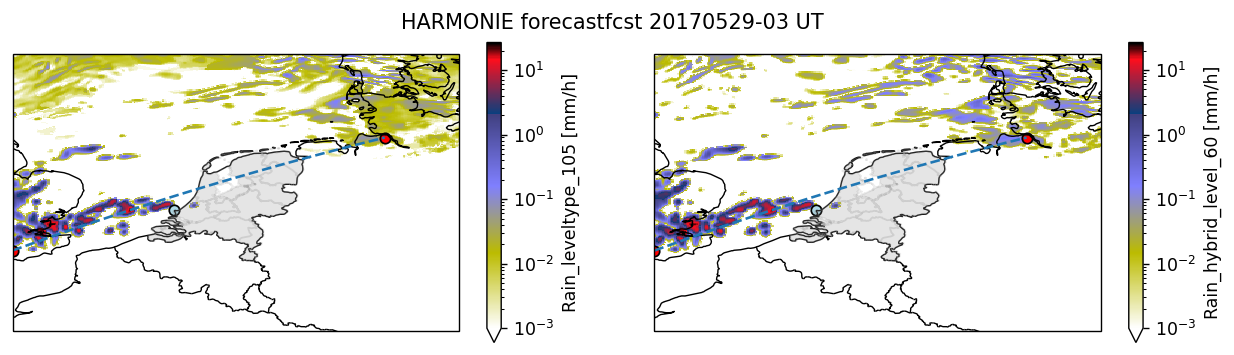

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.15, hspace=0.15)

lon_ = ds1.longitude
lat_ = ds1.latitude

rain_105.plot(cmap='gist_stern_r',
          ax=ax[0],
          robust=True,
          norm=colors.LogNorm(vmin=1e-3,vmax=rain_105.max()),
          transform=ccrs.PlateCarree())

rain_109.plot(cmap='gist_stern_r',
          ax=ax[1],
          robust=True,
          norm=colors.LogNorm(vmin=1e-3,vmax=rain_105.max()),
          transform=ccrs.PlateCarree())

for i in range(0,2):
        ax[i].set_title('')
        ax[i].set_extent((lon_.min(), lon_.max(),
                          lat_.min(), lat_.max()))
        # add Borders and so
        ax[i].coastlines(linewidth=.8, edgecolor='gray')
        ax[i].add_feature(BORDERS, linewidth=.8, edgecolor='black')
        # add Dutch provinces
        ax[i].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                          edgecolor='darkgray', facecolor='gray', alpha=0.2)
        
        
        ax[i].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['start']['lon']%360,
                        path_params['start']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['end']['lon']%360,
                        path_params['end']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(lon%360, lat,
                        c='lightblue', edgecolor='black', transform=ccrs.PlateCarree())
        
title_str = '{model} forecastfcst {time} UT'.format(
    model=my_atmos.model, time=t_fcst)
fig.suptitle(title_str)

fig.savefig('rain_105_109_comparison.png', facecolor='white', bbox_inches = 'tight')